In [1]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers
from tensorflow import keras

In [3]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk

In [4]:
sensorindex = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11]
timesamples = 400
noisedb = -18
encoding_dim = 64
dt = 1e-6
dx = 3456*0.2e-3/12

In [5]:
mat = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces.mat'))

In [6]:
X = mat['concat_traces'].astype('float32')

In [7]:
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (215, 73, 401))

In [8]:
X = X[:,::6,:]

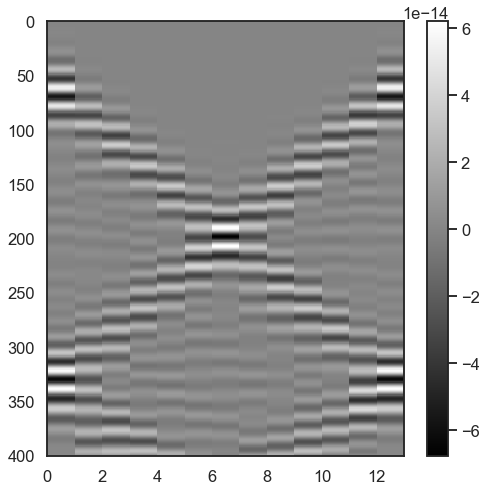

In [9]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [10]:
X.shape[-1]

401

In [11]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

In [12]:
X = np.multiply(X, time_scaling)

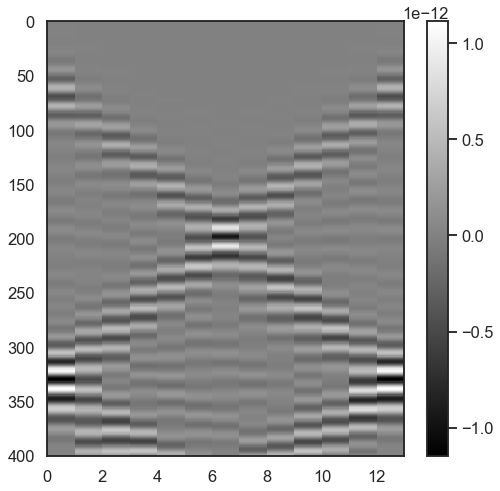

In [13]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [14]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels.csv'))

In [15]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [16]:
labels[(labels['Depression depth'] == 0) & (labels['Pitting depth'] == 0)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var
37,model_c3456_t034_d000_p000_s578,6.8,578,0.0,0.0,476.518271,31.776565,6.8,6.8,6.8,6.8,0.0,0.0
101,model_c3456_t038_d000_p000_s762,7.6,762,0.0,0.0,407.829286,88.888349,7.6,7.6,7.6,7.6,0.0,0.0
174,model_c3456_t041_d000_p000_s026,8.2,26,0.0,0.0,279.222320,51.551318,8.2,8.2,8.2,8.2,0.0,0.0


In [17]:
from acoustics import generator
def make_noise(noisedb, noiseshape):
  noise = np.zeros(noiseshape, dtype='float32')
  noiselev = 10**(noisedb/10)
  for i in range(noiseshape[0]):
    for j in range(noiseshape[1]):
      noise[i, j, :] = generator.noise(noiseshape[2], color='pink')*noiselev
  return noise

In [18]:
X_sample_c = X[:,:,:timesamples]/X.max()
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)
label_sample = labels

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

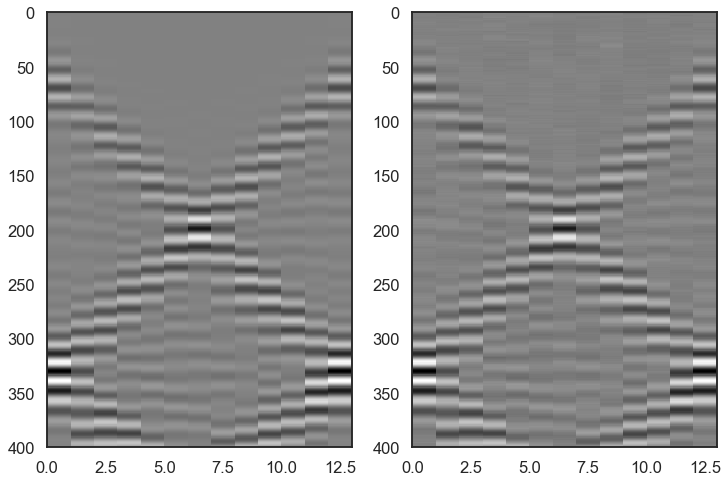

In [19]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()


plt.show()

In [20]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [21]:
X_sample_n = pick_sensors(X_sample_n, sensorindex)
X_sample_c = pick_sensors(X_sample_c, sensorindex)
X_sample_n.shape, X_sample_c.shape

((215, 1, 11, 400), (215, 1, 11, 400))

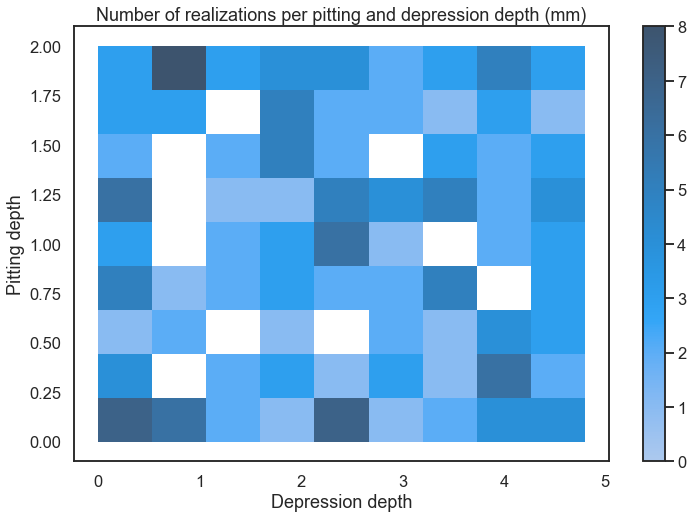

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

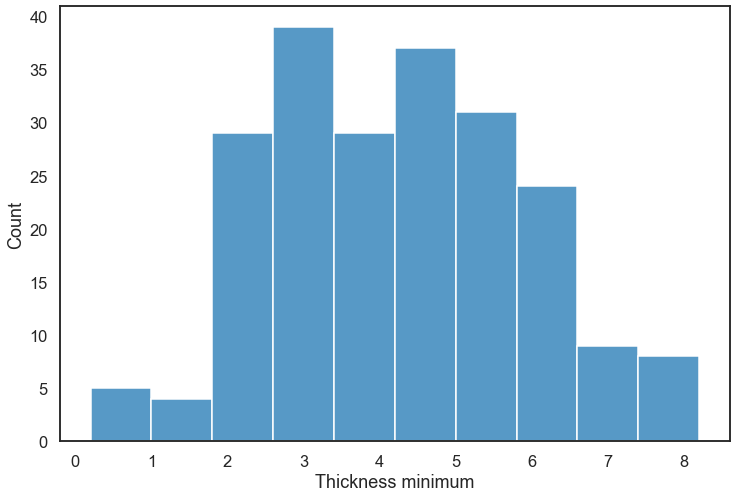

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=False)

plt.show()

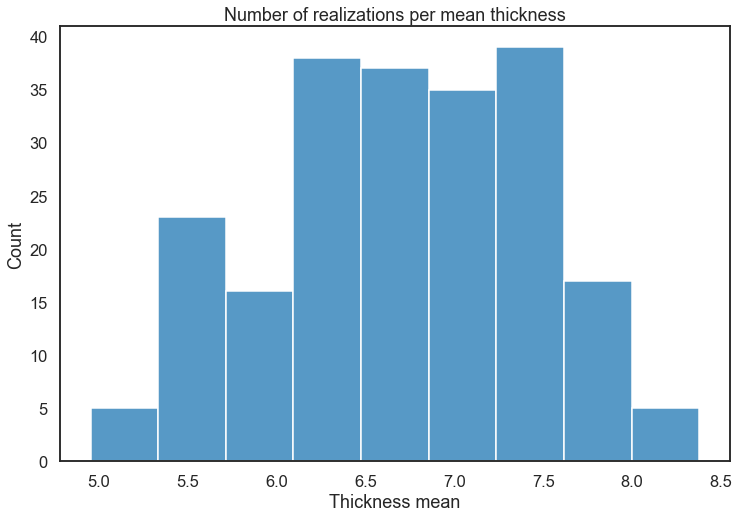

In [24]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

# ML

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=43)

In [26]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

In [27]:
def make_autoencoder_flex(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(encoding_dim*16, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*8, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*4, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*2, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)




  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(encoding_dim*2, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*4, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*8, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*16, activation='tanh')(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0181 - val_loss: 0.0254
Epoch 2/100
1/1 [==============================] - 0s 210ms/step - loss: 0.0252 - val_loss: 0.0195
Epoch 3/100
1/1 [==============================] - 0s 177ms/step - loss: 0.0189 - val_loss: 0.0167
Epoch 4/100
1/1 [==============================] - 0s 196ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 5/100
1/1 [==============================] - 0s 224ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 6/100
1/1 [==============================] - 0s 274ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 7/100
1/1 [==============================] - 0s 210ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 8/100
1/1 [==============================] - 0s 192ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 9/100
1/1 [==============================] - 0s 259ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 10/100
1/1 [==============================] - 0s 251ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 11/100

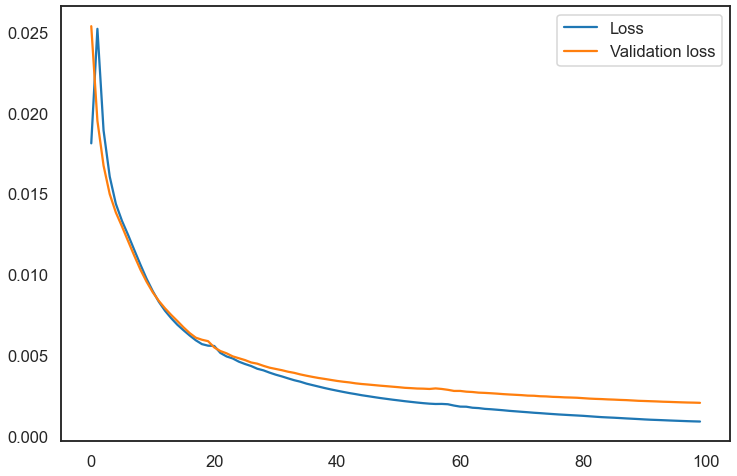

In [28]:
autoencoder, encoder, decoder = make_autoencoder_flex(encoding_dim=encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [29]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4400)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4506624   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [30]:
decoded_traces = autoencoder.predict(x_test_flat)
encoded_traces = encoder.predict(x_test_flat)

2/2 [==============================] - 0s 7ms/step


In [31]:
encoded_traces.shape, decoded_traces.shape

((43, 64), (43, 4400))

In [32]:
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3])

In [33]:
x_test.shape, test_decoded_shaped.shape

((43, 1, 11, 400), (43, 1, 11, 400))

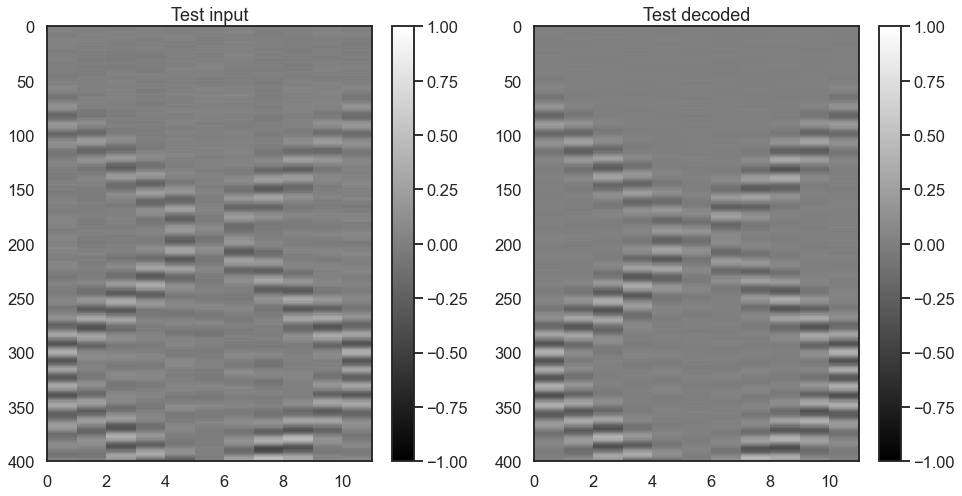

In [34]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

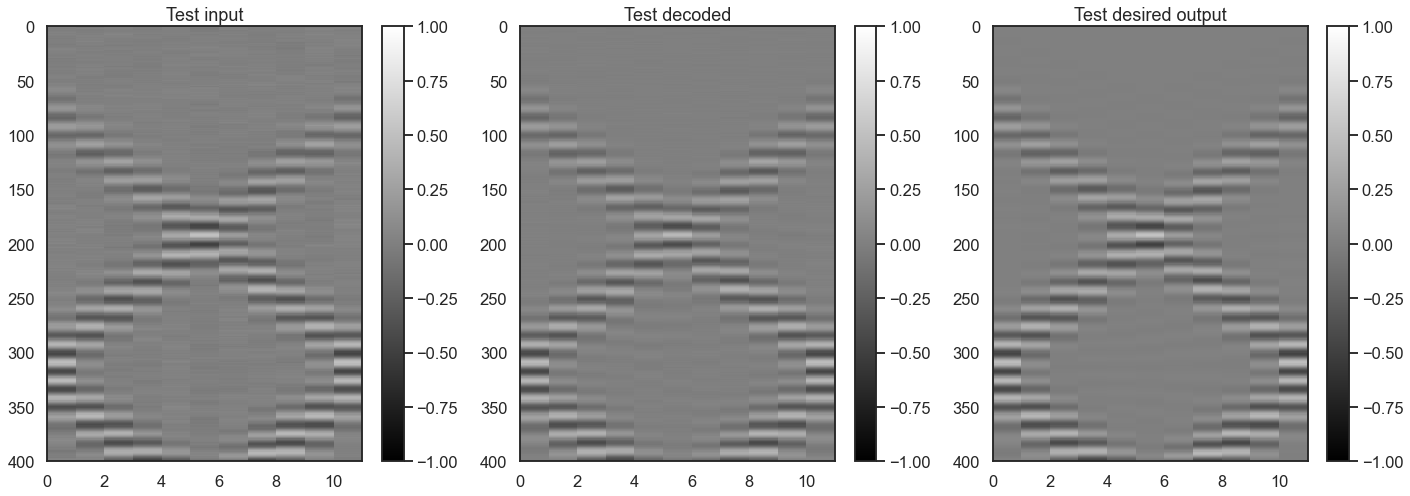

In [35]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [36]:
autoencoder.evaluate(x_test_flat, x_test_flat)

2/2 [==============================] - 0s 10ms/step - loss: 0.0023


0.002290031872689724

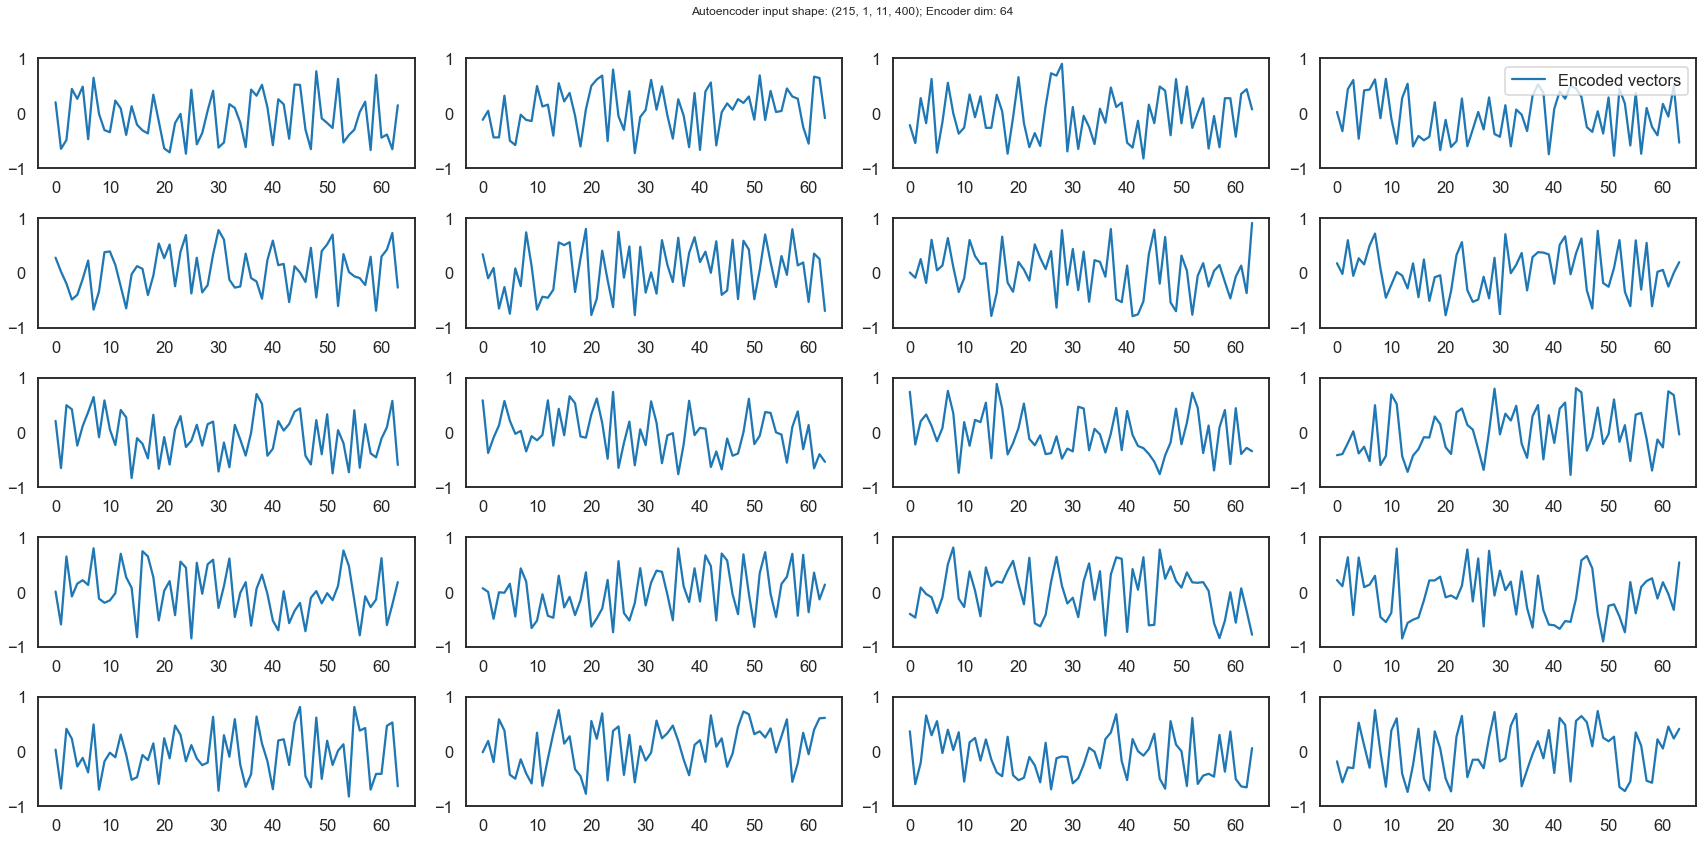

In [37]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)

    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

## Regression

In [38]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))
X_sample_flat.shape

(215, 4400)

In [39]:
encoded_all = encoder.predict(X_sample_flat)

7/7 [==============================] - 0s 9ms/step


In [40]:
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression location','Pitting depth']

In [41]:
def make_regression_model():
  model = Sequential()
  model.add(Dense(encoding_dim, activation='tanh'))
  if encoding_dim > 32:
    model.add(Dense(32, activation='tanh'))
  if encoding_dim > 24:
    model.add(Dense(24, activation='tanh'))
  if encoding_dim > 16:
    model.add(Dense(16, activation='tanh'))
  if encoding_dim > 8:
    model.add(Dense(8, activation='tanh'))
  model.add(Dense(4, activation='tanh'))
  model.add(Dense(1, activation='linear'))
  return model

Thickness mean


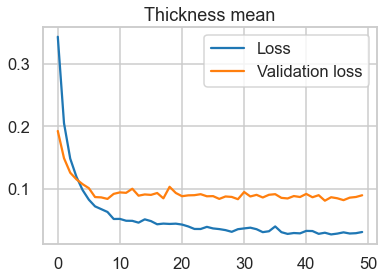

2/2 [==============================] - 0s 6ms/step - loss: 0.0896
loss: 0.08964840322732925
Thickness minimum


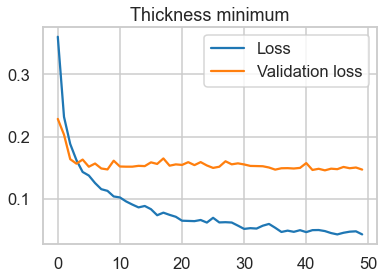

2/2 [==============================] - 0s 7ms/step - loss: 0.1470
loss: 0.14696750044822693
Thickness std


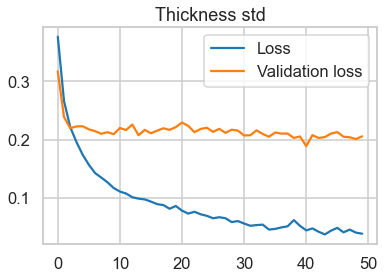

2/2 [==============================] - 0s 6ms/step - loss: 0.2057
loss: 0.20570245385169983
Depression depth


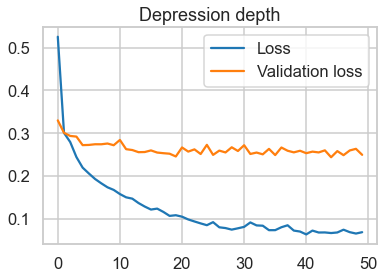

2/2 [==============================] - 0s 4ms/step - loss: 0.2495
loss: 0.24949905276298523
Depression location


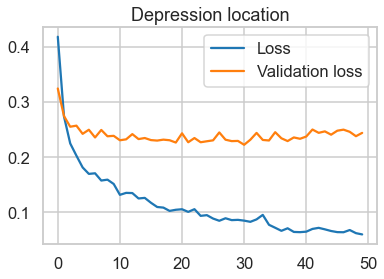

2/2 [==============================] - 0s 3ms/step - loss: 0.2440
loss: 0.24399366974830627
Pitting depth


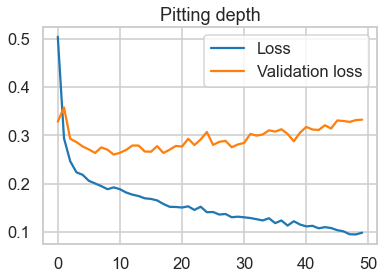

2/2 [==============================] - 0s 5ms/step - loss: 0.3326
loss: 0.33263757824897766


In [42]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
regression_models = {}
min_max_scalers = {}
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(encoded_all, y_reg, test_size=0.2, random_state=42)
  regression_model = make_regression_model()
  regression_model.compile(loss='mae', optimizer='adam')
  history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))

  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = regression_model.predict(x_reg_test)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = regression_model.evaluate(x_reg_test, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)
  regression_models[attribute] = regression_model
  min_max_scalers[attribute] = min_max_scaler

In [43]:
scales = np.array([[4.5, 8],
                   [-0.5, 8],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

In [44]:
def plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=True, title=None):
  sns.set_style('whitegrid')
  sns.set_context('talk')
  attributes = df_test.columns
  plt.figure(figsize=(20, 12))
  for i, attribute in enumerate(attributes):
    y_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))
    df_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])
    df_test_merge['abs_diff'] = abs(df_test_merge['True [mm]'] - df_test_merge['Predicted [mm]'])
    df_test_merge.quantile(q=0.75)['abs_diff']
    df_test_merge['75th percentile'] = np.where(df_test_merge['abs_diff'] < df_test_merge.quantile(q=0.75)['abs_diff'], True, False)
    plt.subplot(2, 3, i+1)
    if perc:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', hue='75th percentile', alpha=0.5)
      plt.legend(loc='upper left', title='75th percentile')
    else:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5)
    textposx = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.5)
    textposy = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.05)
    textstring = "Normalized loss (mae): {:.6f}".format(df_loss.at[0, attribute])
    plt.text(textposx, textposy, textstring, fontsize=11, bbox=dict(facecolor='grey', alpha=0.5))
    plt.plot([df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], [df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], 'r--')
    plt.title(attribute)
    plt.xlim(df_scales.at[0, attribute], df_scales.at[1, attribute])
    plt.ylim(df_scales.at[0, attribute], df_scales.at[1, attribute])

  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  if title:
    plt.suptitle(title, fontsize=12)
  else:
    plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)

  plt.show()

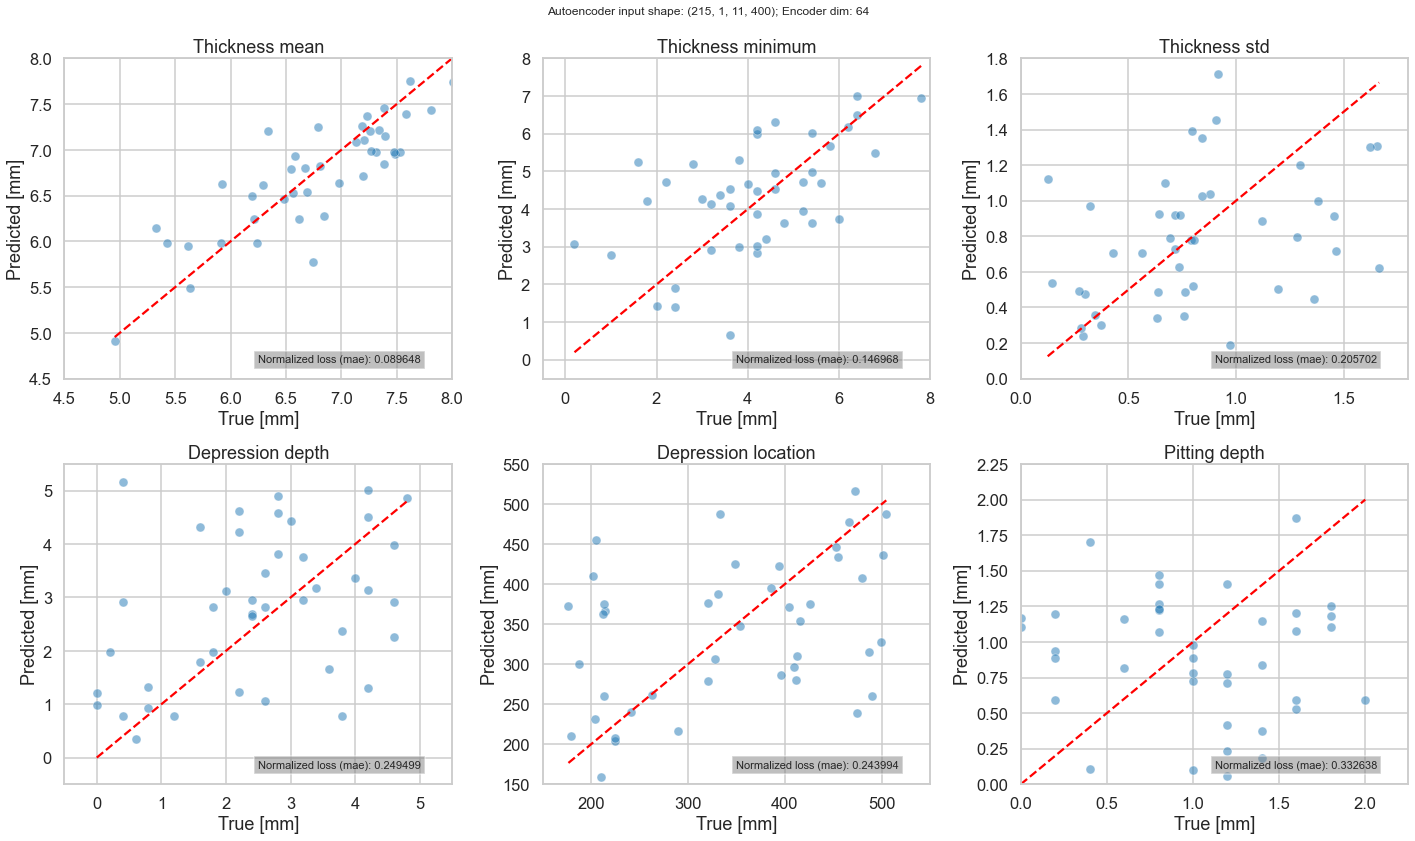

In [45]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False)

## Direct Regression

Thickness mean


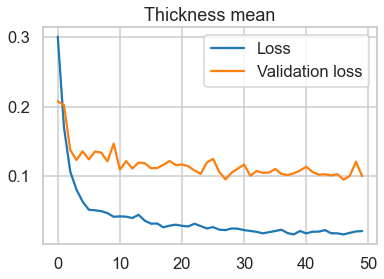

2/2 [==============================] - 0s 5ms/step - loss: 0.0998
loss: 0.09978865832090378
Thickness minimum


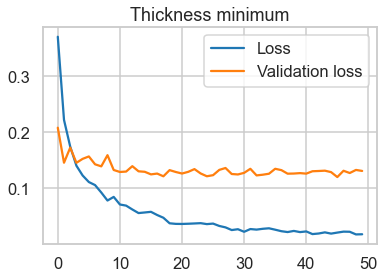

2/2 [==============================] - 0s 5ms/step - loss: 0.1311
loss: 0.13107258081436157
Thickness std


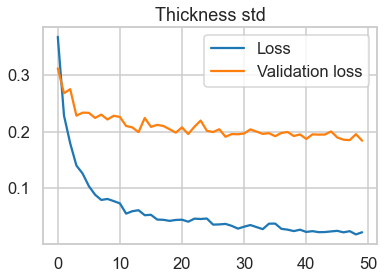

2/2 [==============================] - 0s 5ms/step - loss: 0.1838
loss: 0.18375854194164276
Depression depth


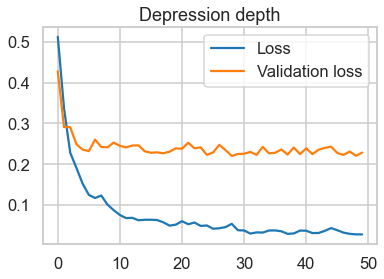

2/2 [==============================] - 0s 4ms/step - loss: 0.2283
loss: 0.2283172607421875
Depression location


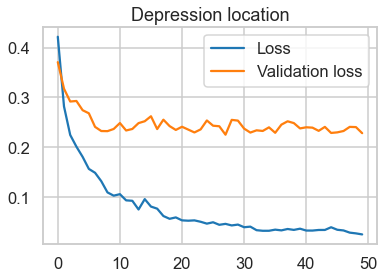

2/2 [==============================] - 0s 4ms/step - loss: 0.2283
loss: 0.2283373326063156
Pitting depth


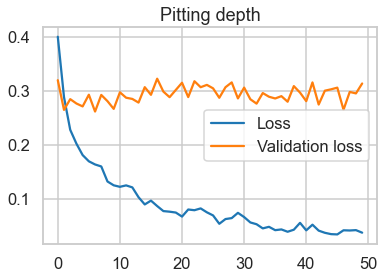

2/2 [==============================] - 0s 5ms/step - loss: 0.3140
loss: 0.3139928877353668


In [46]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(X_sample_n, y_reg, test_size=0.2, random_state=42)
  x_reg_train_flat = x_reg_train.reshape((len(x_reg_train), np.prod(x_reg_train.shape[1:])))
  x_reg_test_flat = x_reg_test.reshape((len(x_reg_test), np.prod(x_reg_test.shape[1:])))
  direct_regression_model = make_regression_model()
  #direct_regression_model = make_direct_regressor()
  direct_regression_model.compile(loss='mae', optimizer='adam')
  history = direct_regression_model.fit(x_reg_train_flat, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test_flat, y_reg_test_norm.astype('float32')))

  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = direct_regression_model.predict(x_reg_test_flat)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = direct_regression_model.evaluate(x_reg_test_flat, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)

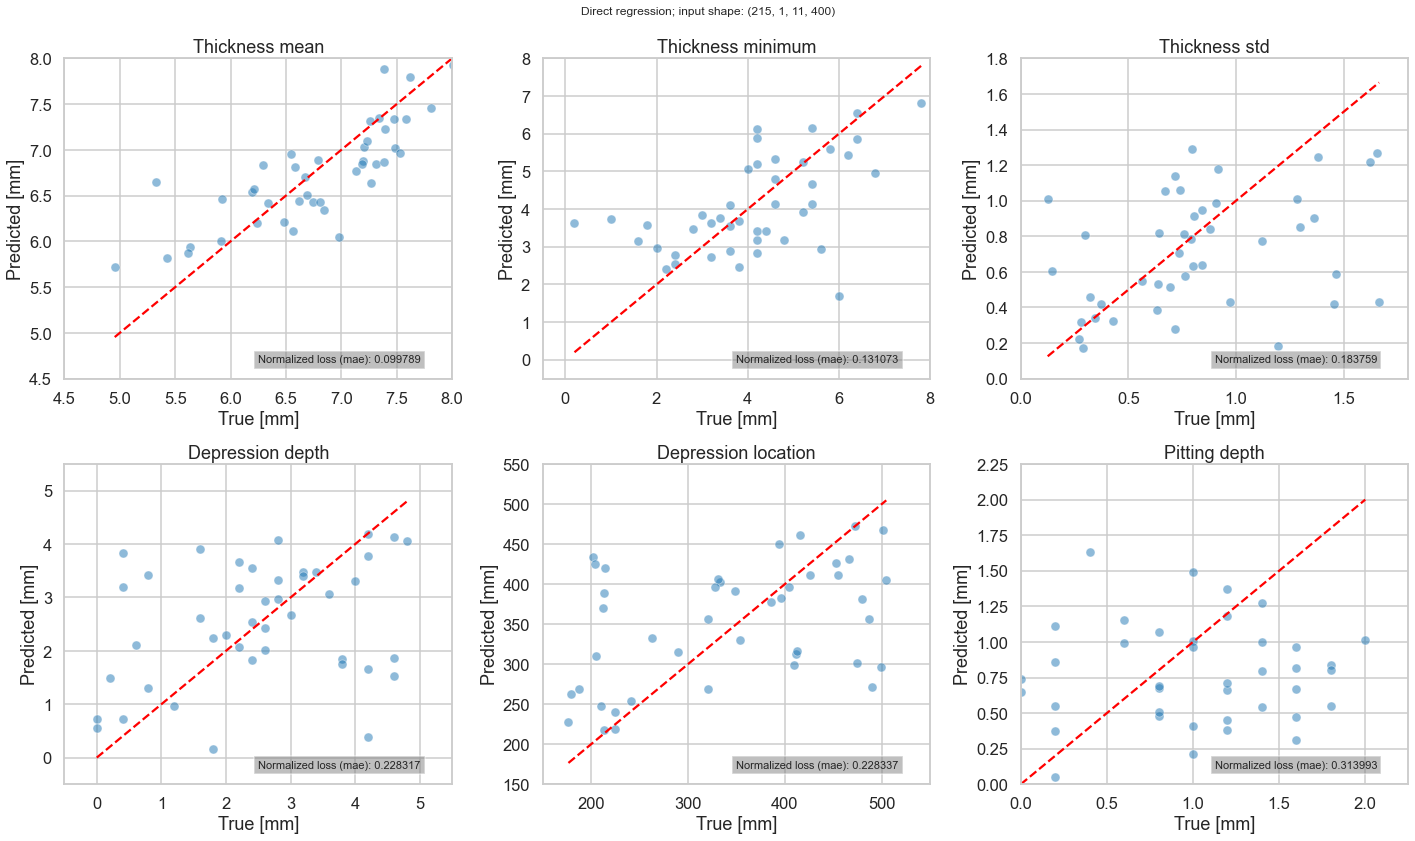

In [47]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct regression; input shape: '+ str(X_sample_n.shape))

# Real data

In [48]:
realdatapath = '../data/input_real/Waveforms_clock_pos/'
df_waveforms, df_time = read_data.read_waveforms(realdatapath)

20220210-01oc-040kHz.csv
20220210-01oc-041kHz.csv
20220210-01oc-042kHz.csv
20220210-01oc-043kHz.csv
20220210-01oc-044kHz.csv
20220210-01oc-045kHz.csv
20220210-01oc-046kHz.csv
20220210-01oc-047kHz.csv
20220210-01oc-048kHz.csv
20220210-01oc-049kHz.csv
20220210-01oc-050kHz.csv
20220210-01oc-051kHz.csv
20220210-01oc-052kHz.csv
20220210-01oc-053kHz.csv
20220210-01oc-054kHz.csv
20220210-01oc-055kHz.csv
20220210-01oc-056kHz.csv
20220210-01oc-057kHz.csv
20220210-01oc-058kHz.csv
20220210-01oc-059kHz.csv
20220210-01oc-060kHz.csv
20220210-01oc-061kHz.csv
20220210-01oc-062kHz.csv
20220210-01oc-063kHz.csv
20220210-01oc-064kHz.csv
20220210-01oc-065kHz.csv
20220210-01oc-066kHz.csv
20220210-01oc-067kHz.csv
20220210-01oc-068kHz.csv
20220210-01oc-069kHz.csv
20220210-01oc-070kHz.csv
20220210-01oc-071kHz.csv
20220210-01oc-072kHz.csv
20220210-01oc-073kHz.csv
20220210-01oc-074kHz.csv
20220210-01oc-075kHz.csv
20220210-01oc-076kHz.csv
20220210-01oc-077kHz.csv
20220210-01oc-078kHz.csv
20220210-01oc-079kHz.csv


In [49]:
first_iter = True
for freq in np.unique(df_waveforms.columns):
  measurement_temp = df_waveforms[freq].to_numpy()[900:4100:5,:-1]
  measurement_temp = measurement_temp/measurement_temp.max()
  if first_iter:
    measurements = np.expand_dims(measurement_temp, axis=0)
    first_iter = False
  else:
    measurements = np.concatenate((measurements, np.expand_dims(measurement_temp, axis=0)), axis=0)

In [50]:
measurements = measurements[:,:timesamples,:]
measurements.shape

(41, 400, 11)

In [51]:
# Filtering
applyfilter = False
if applyfilter:
  for panelno in range(41):
    frq = panelno+40
    cutoff = frq*1.2*1000
    filtered_temp = butter_lowpass_filter(measurements[panelno], cutoff, 4)
    measurements[panelno] = filtered_temp/filtered_temp.max()

In [52]:
measurements.max()

1.0

In [53]:
tracebalancing = False
if tracebalancing:
  for panelno in range(41):
    tracemax = np.zeros(shape=measurements[panelno,1,:].shape)
    for traceno in range(len(tracemax)):
      tracemax[traceno] = measurements[panelno,:,traceno].max()
    measurements[panelno] = np.divide(measurements[panelno], tracemax)

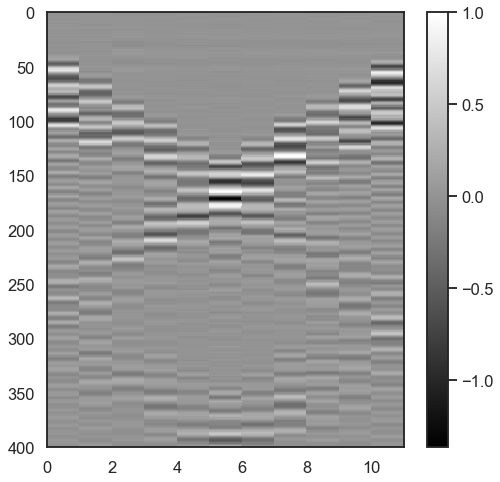

In [54]:
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.pcolor(measurements[20,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [55]:
measurements_flat = measurements.reshape((len(measurements), np.prod(measurements.shape[1:])))
real_autoencoded = autoencoder.predict(measurements_flat)

2/2 [==============================] - 0s 12ms/step


In [56]:
real_autoencoded.shape, measurements.shape

((41, 4400), (41, 400, 11))

In [57]:
real_autoencoded_shaped = real_autoencoded.reshape(41, 11, timesamples)
real_autoencoded_shaped.shape

(41, 11, 400)

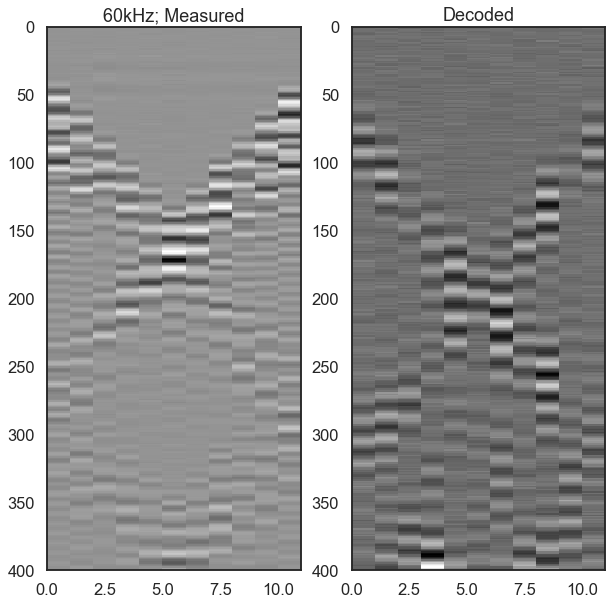

In [58]:
freq = 60
sns.set_style('white')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[freq-40,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.title(str(freq) + 'kHz; Measured')
plt.subplot(1,2,2)
plt.pcolormesh(real_autoencoded_shaped[freq-40,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Decoded')
plt.show()

In [59]:
real_encoded = encoder.predict(measurements_flat)

2/2 [==============================] - 0s 8ms/step


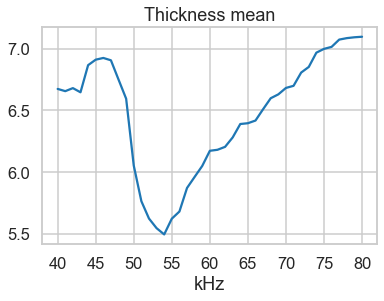

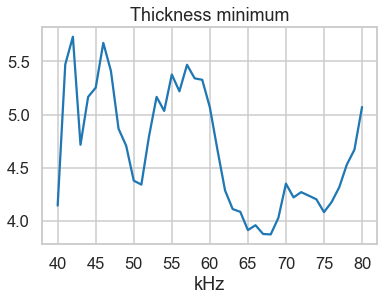

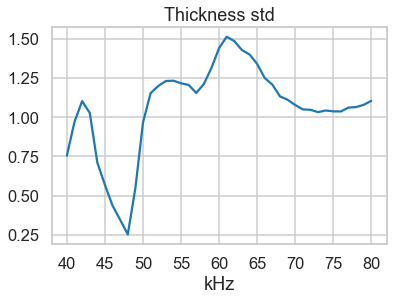

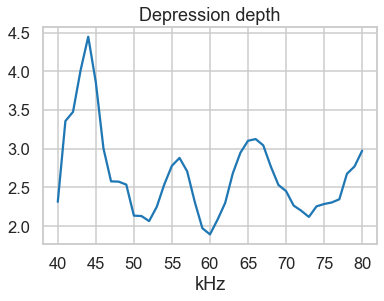

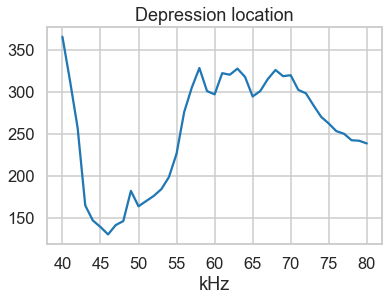

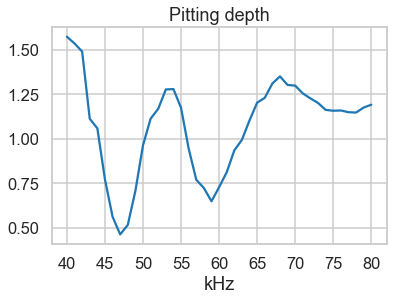

In [60]:
sns.set_context('talk')
sns.set_style('whitegrid')
for attribute in attributes:
  real_prediction_norm = regression_models[attribute](real_encoded)

  real_prediction = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.plot(real_prediction)
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
  plt.show()

# FK

In [117]:
def make_fk_samples(X, dt, dx, fk_maxfreq=120e3, returncomplex=False):
  X_fk = np.zeros(shape=X.shape)
  X_fk = np.swapaxes(X_fk, 2, 3)
  X_fk = np.expand_dims(X_fk, 2)
  X_fk = np.repeat(X_fk, 2, axis=2)
  print(X_fk.shape)
  for i in range(X_fk.shape[0]):
    for j in range(X_fk.shape[1]):
      if returncomplex:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_real = np.real(fk_temp)
        fk_temp_im = np.imag(fk_temp)
        X_fk[i,j,0,:,:] = fk_temp_real/400
        X_fk[i,j,1,:,:] = fk_temp_im/400

      else:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_amp = np.abs(fk_temp)/np.max(np.abs(fk_temp))
        #fk_temp_amp = np.log10(fk_temp_amp)
        fk_temp_amp = minmax_scale(fk_temp_amp)
        fk_temp_angle = np.unwrap(np.angle(fk_temp))
        fk_temp_angle = minmax_scale(fk_temp_angle)
        X_fk[i,j,0,:,:] = fk_temp_amp
        X_fk[i,j,1,:,:] = fk_temp_angle



  #fk_maxfreq = 120e3
  fk_f_indeces = np.where((f_array >= 0) & (f_array <= fk_maxfreq))

  f_array = f_array[fk_f_indeces[0]]
  X_fk = X_fk[:,:,:,fk_f_indeces[0],:]

  return X_fk, x_array, f_array

In [118]:
X_sample_n_fk, x_array, f_array = make_fk_samples(X_sample_n, dt, dx)
X_sample_c_fk, x_array, f_array = make_fk_samples(X_sample_c, dt, dx)

(215, 1, 2, 400, 11)
(215, 1, 2, 400, 11)


In [135]:
X_sample_n.shape

(215, 1, 11, 400)

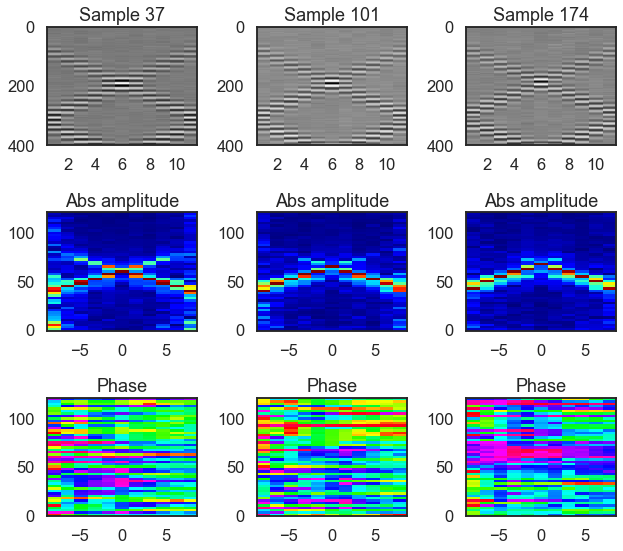

In [120]:
cases = [37, 101, 174]
clock_array = np.array([2, 4, 6, 8, 10])
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(3*len(cases),8))
for i, case in enumerate(cases):
  plt.subplot(3, len(cases), i+1)
  #plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet')
  plt.pcolormesh(X_sample_n[case,0,:,:].T, cmap='gray')
  plt.gca().invert_yaxis()
  plt.xticks(ticks=clock_array-0.5, labels=clock_array)
  #plt.title('Sample ' + str(case) + '; Thickness min: ' + str(np.round(labels.iloc[case]['Thickness minimum']*0.2, decimals=1)))

  plt.title('Sample ' + str(case))
  plt.subplot(3, len(cases), i+len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,0,:,:], cmap='jet')
  plt.title('Abs amplitude')
  #plt.colorbar()
  plt.subplot(3, len(cases), i+2*len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,1,:,:], cmap='hsv')
  plt.title('Phase')
  #plt.colorbar()
  #plt.colorbar()
plt.tight_layout()
plt.show()

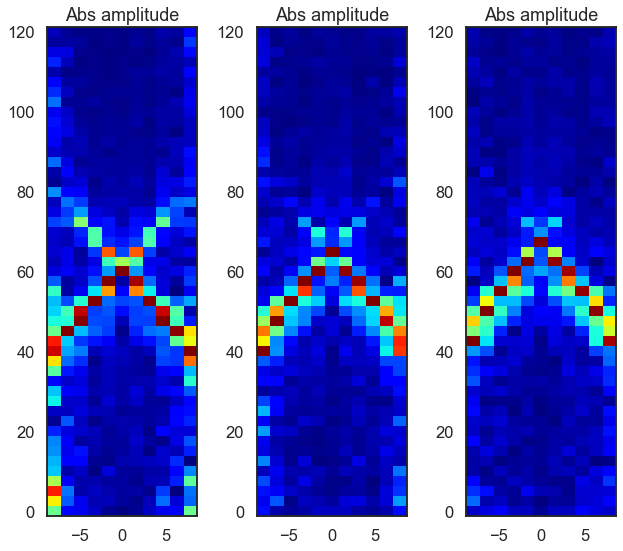

In [171]:
cases = [37, 101, 174]
clock_array = np.array([2, 4, 6, 8, 10])
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(3*len(cases),8))
for i, case in enumerate(cases):
  plt.subplot(1, len(cases), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,:,:], cmap='jet')
  plt.title('Abs amplitude')#plt.title('Sample ' + str(case) + '; Thickness min: ' + str(np.round(labels.iloc[case]['Thickness minimum']*0.2, decimals=1)))
plt.tight_layout()
plt.show()

In [121]:
amp_only = True
if amp_only:
  X_sample_n_fk = X_sample_n_fk[:,:,0,:,:]
  X_sample_c_fk = X_sample_c_fk[:,:,0,:,:]

In [122]:
X_sample_n_fk.shape, X_sample_n_fk.max(), X_sample_c_fk.shape

((215, 1, 49, 11), 1.0000000000000002, (215, 1, 49, 11))

In [123]:
x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_fk, X_sample_c_fk, test_size=0.2, random_state=42)

In [124]:
x_train_flat_fk = x_train_fk.reshape((len(x_train_fk), np.prod(x_train_fk.shape[1:])))
x_test_flat_fk = x_test_fk.reshape((len(x_test_fk), np.prod(x_test_fk.shape[1:])))
y_train_flat_fk = y_train_fk.reshape((len(y_train_fk), np.prod(y_train_fk.shape[1:])))
y_test_flat_fk = y_test_fk.reshape((len(y_test_fk), np.prod(y_test_fk.shape[1:])))

In [125]:
x_train_flat_fk.shape, x_test_flat_fk.shape, y_train_flat_fk.shape, y_test_flat_fk.shape

((172, 539), (43, 539), (172, 539), (43, 539))

In [126]:
def make_autoencoder_fk(encoding_dim=16):

  input_trace = keras.Input(shape=(x_train_flat_fk.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(encoding_dim*16, activation='relu')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*8, activation='relu')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*4, activation='relu')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*2, activation='relu')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(encoding_dim*2, activation='relu')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*4, activation='relu')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*8, activation='relu')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*16, activation='relu')(decoded)
  decoded = layers.Dense(x_train_flat_fk.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0578 - val_loss: 0.0622
Epoch 2/100
1/1 [==============================] - 0s 75ms/step - loss: 0.0570 - val_loss: 0.0607
Epoch 3/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0556 - val_loss: 0.0578
Epoch 4/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0530 - val_loss: 0.0526
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0484 - val_loss: 0.0448
Epoch 6/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0416 - val_loss: 0.0364
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0345 - val_loss: 0.0340
Epoch 8/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0329 - val_loss: 0.0273
Epoch 9/100
1/1 [==============================] - 0s 125ms/step - loss: 0.0269 - val_loss: 0.0222
Epoch 10/100
1/1 [==============================] - 0s 76ms/step - loss: 0.0222 - val_loss: 0.0205
Epoch 11/100
1/1 [==

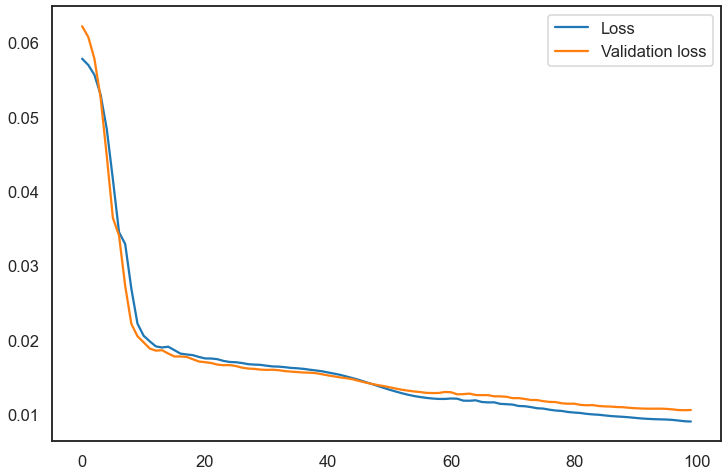

In [127]:
autoencoder_fk, encoder_fk, decoder_fk = make_autoencoder_fk(encoding_dim=24)
autoencoder_fk.compile(optimizer='adam', loss='mse')

history = autoencoder_fk.fit(x_train_flat_fk, y_train_flat_fk,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat_fk, y_test_flat_fk))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [128]:
decoded_traces_fk = autoencoder_fk.predict(x_test_flat_fk)
encoded_traces_fk = encoder_fk.predict(x_test_flat_fk)

2/2 [==============================] - 0s 3ms/step


In [129]:
decoded_shaped_fk = decoded_traces_fk.reshape(len(decoded_traces_fk), y_test_fk.shape[1], y_test_fk.shape[2], y_test_fk.shape[3])

In [130]:
decoded_shaped_fk.shape, x_test_fk.shape

((43, 1, 49, 11), (43, 1, 49, 11))

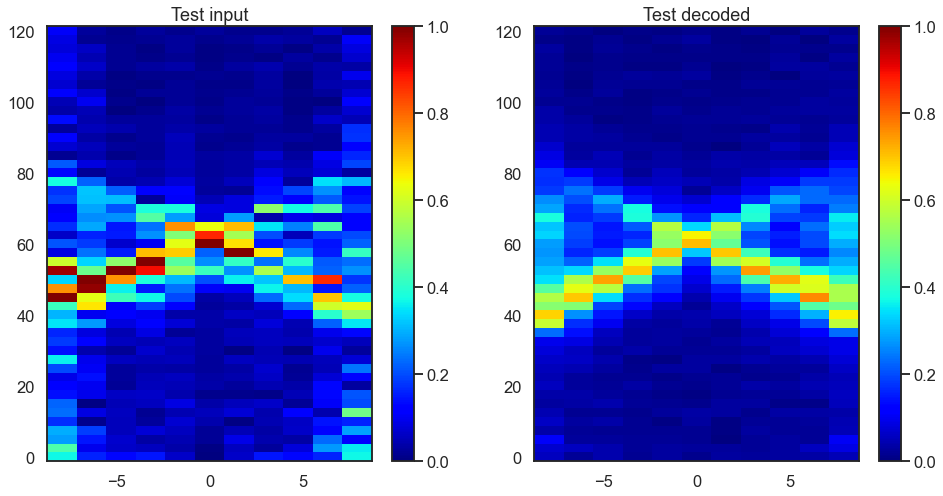

In [131]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

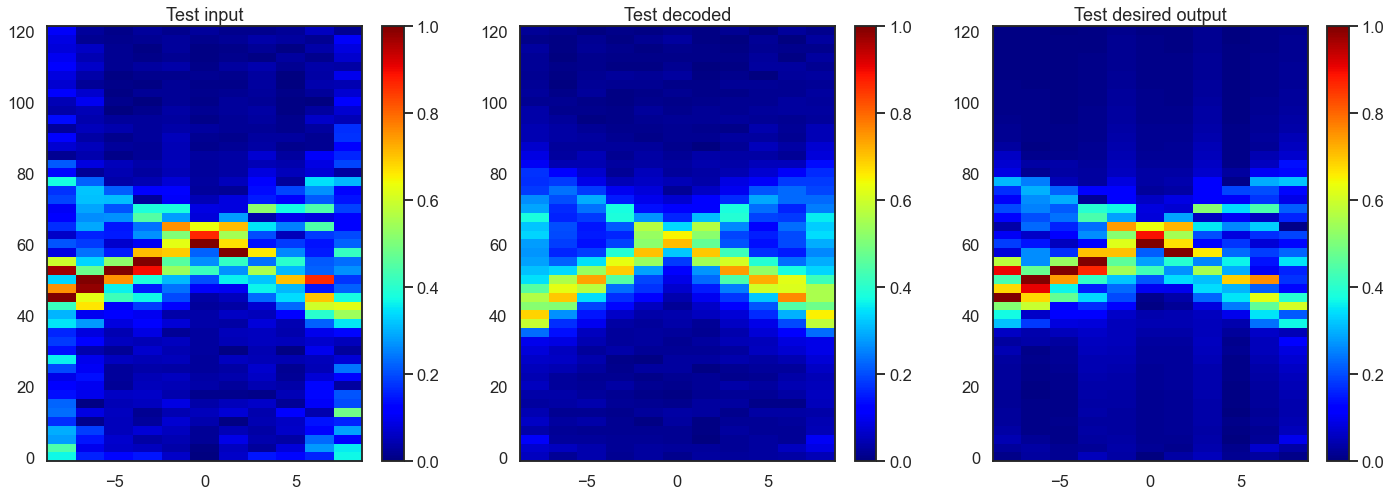

In [132]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(x_array, f_array/1e3, y_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [137]:
measurements_mod = measurements.swapaxes(1,2)


In [139]:
measurements_mod = np.expand_dims(measurements_mod, 1)

In [140]:
measurements_mod.shape, X_sample_n.shape

((41, 1, 11, 400), (215, 1, 11, 400))

In [142]:
measurements_fk, x_array, f_array = make_fk_samples(measurements_mod, dt, dx)

(41, 1, 2, 400, 11)


In [146]:
if amp_only:
  measurements_fk = measurements_fk[:,:,0,:,:]

In [148]:
measurements_flat_fk = measurements_fk.reshape((len(measurements_fk), np.prod(measurements_fk.shape[1:])))

In [149]:
measurements_flat_fk.shape

(41, 539)

In [150]:
decoded_measurements_fk = autoencoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 8ms/step


In [152]:
decoded_measurements_shaped_fk = decoded_measurements_fk.reshape(len(decoded_measurements_fk), measurements_fk.shape[1], measurements_fk.shape[2], measurements_fk.shape[3])

In [154]:
decoded_measurements_shaped_fk.shape

(41, 1, 49, 11)

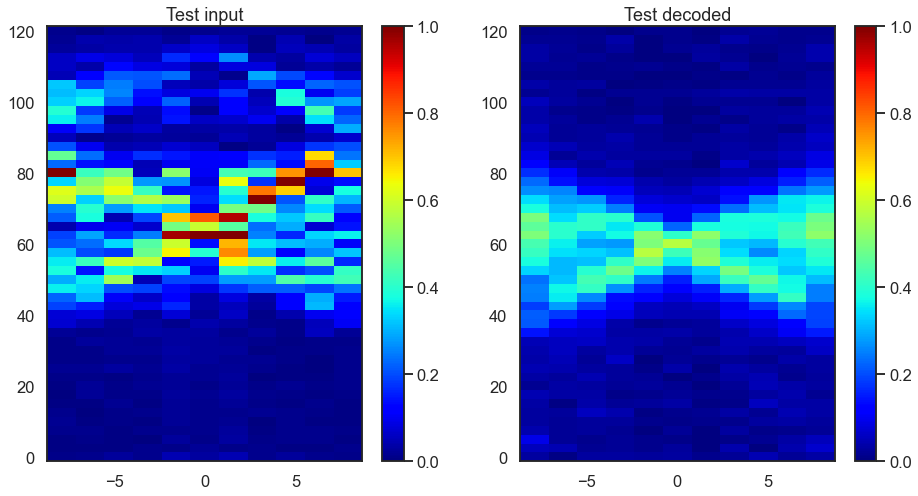

In [167]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_array, f_array/1e3, measurements_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

#plt.subplot(1, 3, 3)
#plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
#plt.colorbar()
#plt.title('Test desired output')



plt.show()